## Fine-tuning Large Language Models for Sentiment Analysis of Central Bank Speeches
[![Portfolio](https://img.shields.io/badge/Moritz_Pfeifer-CentralBankBERTa-blue?logo=GitHub)](https://github.com/Moritz-Pfeifer/CentralBankBERTa)

# A - Introduction

Today, central bank communications are considered an important monetary policy tool. Through communications, central banks have been said to guide the economy. Communications are supposed to help the central bank better fulfill monetary policy goals such as price stability, stable interest rates or employment. A bourgeoning literature has explored the use of natural language processing (NLP) to analyze central bank communications.

Most, if not all, of these studies rely on NLP algorithms that assume a bag-of-words structure. That is, the algorithms ignore context and instead analyze text as a collection of individual words treated independently without regard for grammar or word order.

More recently, research in computational linguistics has introduced deep-learning-based NLP algorithms often referred to as large language models (LLMs) due to their large number of parameters (up to billions). These algorithms learn semantic and syntactic relations among words from a large volume of texts, which allows them to consider context. Using a sample of pre-labeled sentences from the Federal Reserve Bank, the aim of this research is to test whether state-of-the-art LLMs outperform other machine learning algorithms such as naïve Bayes, Support Vector Machines or random forest in sentiment classification.

# B - Setup

## 1. Load Essential Libraries

In [ ]:
import os
import re
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2. Upload Datasets

The dataset contains 6683 sentences of Fed speeches from 1949-2022 pre-classified by four audiences: 1) public, 2) firms, 3) banks and 4) the government. The script for the audience classification can be found [here](www.insertlink.com). The task is to attribute a sentiment to each sentence.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = os.getcwd()+'/drive/MyDrive/CentralBankBERTa/Sentiment_classification'
path

'/content/drive/MyDrive/CentralBankBERTa/Sentiment_classification'

### 2.1. Load Train Data

#### FED
The dataset contains 6683 sentences of Fed speeches from 1949-2022 pre-classified by four audiences: 1) public, 2) firms, 3) banks and 4) the government. The script for the audience classification can be found [here](www.insertlink.com). The task is to attribute a sentiment to each sentence.

In [ ]:
data_train_FED = pd.read_csv(path+'/data_input/FED_prelabelled_sent.csv')
data_train_FED = data_train_FED.drop(['audience'], axis=1)
data_train_FED.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6683 entries, 0 to 6682
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       6683 non-null   object
 1   sentiment  6683 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 104.5+ KB


#### ECB

The dataset contains an additional 2563 meta-labels generated from the RoBERTa model on the ECB dataset with an aggregated threshold of 87%.

In [ ]:
data_train_ECB = pd.read_csv(path+'/data_input/ECB_prelabelled_sent.csv')
data_train_ECB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2563 non-null   object
 1   sentiment  2563 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 40.2+ KB


#### BIS

The dataset contains an additional 4212 meta-labels generated from the RoBERTa model on the BIS dataset with an aggregated threshold of 87%.

In [ ]:
data_train_BIS = pd.read_csv(path+'/data_input/BIS_prelabelled_sent.csv')
data_train_BIS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4212 entries, 0 to 4211
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4212 non-null   object
 1   sentiment  4212 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 65.9+ KB


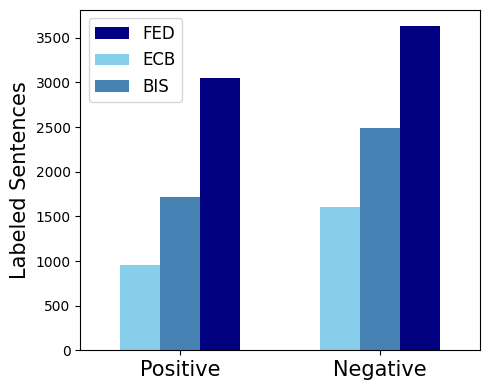

In [ ]:
plt.figure(figsize=(5, 4))
width = .2
sentiment = ('Positive', 'Negative')
ax1 = data_train_FED['sentiment'].value_counts().sort_index(ascending=False).plot(kind='bar', color='navy', position=-.5, width = width, label="FED")
ax2 = data_train_ECB['sentiment'].value_counts().sort_index(ascending=False).plot(kind='bar', color='skyblue', position=1.5, width = width, label='ECB')
ax3 = data_train_BIS['sentiment'].value_counts().sort_index(ascending=False).plot(kind='bar', color='steelblue', position=0.5, width = width, label='BIS')
plt.xticks(range(0,2), sentiment, rotation = 0, fontsize=15)
plt.ylabel("Labeled Sentences", fontsize=15)
plt.xlim((-0.5, 1.5))
plt.legend(fontsize=12)
plt.tight_layout();
plt.savefig(path+'/Sentiment_data.png', dpi=300)
plt.show()

### 2.2. Merge all training data together
We create a seperate dataset which concatenates all the four training datasets.

In [ ]:
data_train = pd.concat([data_train_FED, data_train_ECB, data_train_BIS])
print(data_train.shape)
print(data_train['sentiment'].value_counts())

(13458, 2)
0    7730
1    5728
Name: sentiment, dtype: int64


## Split Data into Train and Test Sets

The training data set is split into two sets: a train set with 80% of the data and a validation set with 20% of the data.

In [ ]:
from sklearn.model_selection import train_test_split

X = data_train.text.values
y = data_train.sentiment.values

# Set complete_data to True, if you don't want to split data

complete_data = False

if complete_data is False:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print('Data is split into 80% train and 20% validation sets.')
else:
    X_train, X_val, y_train, y_val = X, X, y, y
    print('Data is not split.')

lengthXtrain = len(X_train)
lengthXval = len(X_val)
print('There are ' + str(lengthXtrain) + ' training labels')
print('There are ' + str(lengthXval) + ' validation labels')

Data is split into 80% train and 20% validation sets.
There are 10766 training labels
There are 2692 validation labels


## 4. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


# C - TF-IDF + Naive Bayes Classifier

Following, the [Scikit-learn's guide](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), here we first use a basic TF-IDF to vectorize the text data. In a second step we will use the Naive Bayes model as our classifier.

## 1. TF-IDF Vectorizer

In information retrieval, **TF-IDF**, short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding the data to machine learning algorithms.

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train = np.array([text for text in X_train])
X_val = np.array([text for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_val)

CPU times: user 2.1 s, sys: 80.2 ms, total: 2.18 s
Wall time: 2.17 s


## 2. Train Naive Bayes Classifier

### 2.1. Hyperparameter Tuning

In order to set hyperparameters for the model, we use   cross-validation and AUC score. The average AUC score from cross-validation will be called via the `get_auc_CV` function.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring='roc_auc', cv=kf)

    return auc.mean()

The MultinominalNB class only have one hypterparameter - alpha. We use the code below to determine what alpha value will give us the best CV AUC score.



Best alpha: 0.28


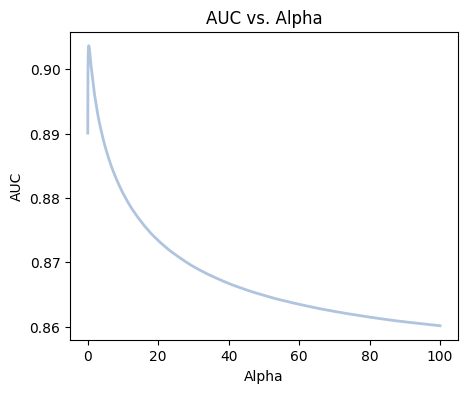

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(alpha=i)) for i in np.arange(0.01, 100, 0.01)], index=np.arange(0.01, 100, 0.01))
best_alpha = np.round(res.idxmax(), 2)
print('Best alpha:', best_alpha)

plt.figure(figsize=(5,4))
plt.plot(res, color='lightsteelblue', linewidth=2)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

### 2.2. Evaluation on Validation Set

We assess the performance of the model and compute the accuracy rate and the AUC score on the validation set.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.figure(figsize=(5,4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color='lightsteelblue', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],color='navy', linestyle='-')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8929
Accuracy: 76.04%


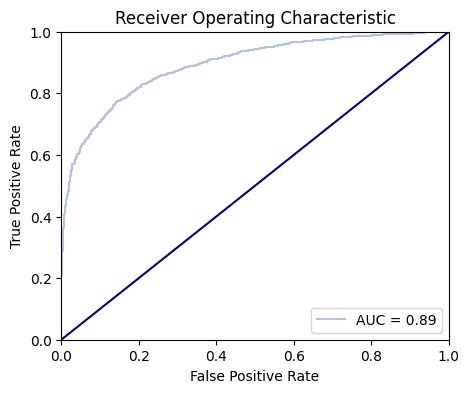

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

In [ ]:
y_pred = nb_model.predict(X_val_tfidf)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.99      0.83      1546
           1       0.96      0.46      0.62      1146

    accuracy                           0.76      2692
   macro avg       0.83      0.72      0.72      2692
weighted avg       0.82      0.76      0.74      2692



#D - Support vector machines (SVMs)  

Support vector machines (SVMs) are a set of supervised learning techniques for solving classification and regression problems. SVMs are classifiers based on two key ideas, which allow to treat nonlinear discrimination problems, and to reformulate the classification problem as a quadratic optimization problem.

Here we will fine-tune a suppert vector machine model and apply it to our dataset.

In [ ]:
# Library for Support Vector Machine
from sklearn import svm, model_selection, preprocessing

In [ ]:
# Create SVM Classifier
svm_clf = svm.SVC(C=10, gamma=0.5, kernel='rbf', probability=True) # best params

# Train algo on training data
svm_clf.fit(X_train_tfidf, y_train)

# Predict target for testing data
y_pred = svm_clf.predict(X_val_tfidf)


In [ ]:
parameters = {'C':[0.1,1,10],
              'kernel': ['linear','rbf','poly'],
              'gamma':[0.001, 0.1, 0.5]}
grid_svm_clf = model_selection.GridSearchCV(estimator=svm_clf, param_grid=parameters)
grille = grid_svm_clf.fit(X_train_tfidf, y_train)

In [ ]:
#print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])
grid_svm_clf.best_params_

AUC: 0.9028
Accuracy: 82.54%


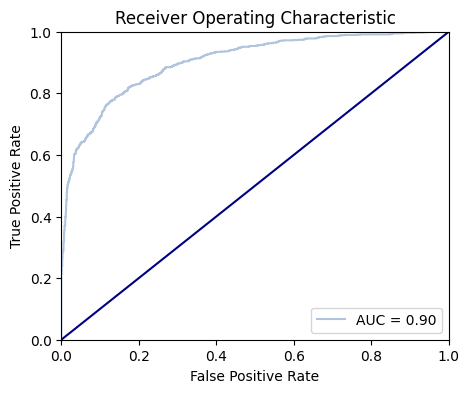

In [ ]:
probs = svm_clf.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

In [ ]:
y_pred = svm_clf.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1546
           1       0.82      0.77      0.79      1146

    accuracy                           0.83      2692
   macro avg       0.83      0.82      0.83      2692
weighted avg       0.83      0.83      0.83      2692



# E - Random Forest Algorithm

A supervised machine learning algorithm that assigns data to categories by building several decision trees and aggregating the outputs of these trees. Each tree is built using a random sample of training data and input variable.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Create Random Forest Classifier object
forest = RandomForestClassifier(random_state=1)

# Train algo on training data
forest.fit(X_train_tfidf, y_train)

# Predict target for testing data
y_pred = forest.predict(X_val_tfidf)

print("Classification Report")
confusion_report = classification_report(y_val, y_pred)
print(confusion_report)

print("\nConfusion Matrix")
confusion_attack = confusion_matrix(y_val, y_pred)
print(confusion_attack)
"""
# plotROC(forest, X_test, y_test, 0, 0)
from sklearn import metrics
metrics.plot_roc_curve(forest, X_val_tfidf, y_val);
"""

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1546
           1       0.80      0.69      0.74      1146

    accuracy                           0.80      2692
   macro avg       0.80      0.78      0.79      2692
weighted avg       0.80      0.80      0.79      2692


Confusion Matrix
[[1351  195]
 [ 353  793]]


'\n# plotROC(forest, X_test, y_test, 0, 0)\nfrom sklearn import metrics\nmetrics.plot_roc_curve(forest, X_val_tfidf, y_val); \n'

AUC: 0.8708
Accuracy: 79.49%


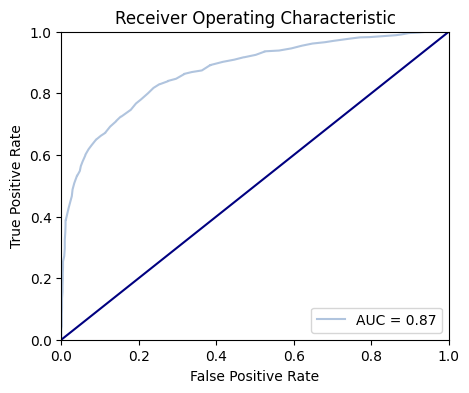

In [ ]:
probs = forest.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

# F - Neural Network Model (LSTM)


Here we are trying to achieve better results with a Recurrent Neural Network. Recurrent neural networks are networks with loops in them, allowing information to persist.

In [ ]:
# Load libraries
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

We define the number of max features as 10000 and use a Tokenizer to vectorize and convert text into sequences so the Network can deal with it as input.

In [ ]:
# Optimal Hyperperameters computed with the Adaptive Experimentation Platform ax
('learning_rate', 0.00037497085604522795)
('dropout_rate', 0.3704542676887013)
('lstm_units', 7)
('neurons_dense', 295)
('num_epochs', 3)
('batch_size', 64)
('embedding_size', 159)
('max_text_len', 595)

{'keras_cv': 0.7178105882662403}

{'keras_cv': 0.7178105882662403}

In [ ]:
max_fatures = 20000
max_text_len = 595
tokenizer = Tokenizer(num_words=max_fatures)
tokenizer.fit_on_texts(data_train['text'])
X = tokenizer.texts_to_sequences(data_train['text'])
X = pad_sequences(X, maxlen=max_text_len).astype('float32')

In [ ]:
# Define the train and test datasets
Y = pd.get_dummies(data_train['sentiment']).values.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10766, 595) (10766, 2)
(2692, 595) (2692, 2)


In [ ]:
adam = optimizers.Adam(learning_rate=0.00037497085604522795)
batch_size=64
epochs=3

inputs = tf.keras.Input(shape=(max_text_len,))

x = layers.Embedding(max_fatures, 159)(inputs)
x = layers.LSTM(units=7)(x)
x = layers.Dense(295, activation="relu")(x)
x = layers.Dropout(0.3704542676887013)(x)
x = layers.Flatten()(x)

outputs = layers.Dense(2, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.AUC()])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 595)]             0         
                                                                 
 embedding (Embedding)       (None, 595, 159)          3180000   
                                                                 
 lstm (LSTM)                 (None, 7)                 4676      
                                                                 
 dense (Dense)               (None, 295)               2360      
                                                                 
 dropout (Dropout)           (None, 295)               0         
                                                                 
 flatten (Flatten)           (None, 295)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 592   

In [ ]:
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test,Y_test))

Epoch 1/3
169/169 [==============================] - 37s 167ms/step - loss: 0.5154 - auc: 0.8231 - val_loss: 0.4204 - val_auc: 0.8915
Epoch 2/3
169/169 [==============================] - 14s 83ms/step - loss: 0.2797 - auc: 0.9522 - val_loss: 0.4104 - val_auc: 0.9001
Epoch 3/3
169/169 [==============================] - 8s 44ms/step - loss: 0.1648 - auc: 0.9829 - val_loss: 0.4898 - val_auc: 0.8938


In [ ]:
model.evaluate(X_test,Y_test)

85/85 [==============================] - 1s 9ms/step - loss: 0.4898 - auc: 0.8938


[0.4897593855857849, 0.8937586545944214]

In [ ]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(Y_test, axis=1)

85/85 [==============================] - 1s 8ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1517
           1       0.84      0.70      0.76      1175

    accuracy                           0.81      2692
   macro avg       0.81      0.80      0.80      2692
weighted avg       0.81      0.81      0.81      2692



# G - Fine-tuning Large Language Models

The NLP/ML approaches tested above only yield limited results, with an accuracy of 60.43% for naïve Bayes (NB), 50.11% for LSTM, 65.45% for SVMs, and 65% for random forests. We will therefore test four different large language models to see if they perform better.

## 1. Install the Hugging Face Library

Hugging Face's transformer library includes pre-trained model weights and PyTorch implementations of cutting-edge NLP models like BERT (from Google) and GPT (from OpenAI).

In [ ]:
#Stable version
!pip install transformers==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Required for XLNnet transformer model
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. Fine Tuning the Models

The model predicts two possible sentiment values for each input sentence:

> 0: Negative <br>
> 1: Positive


We will fine-tune the following large language models and compare the results on our dataset:

> 1) BERT<br>
> 2) XLNet <br>
> 3) FinNBERT <br>
4) RoBERTa

In [ ]:
from scipy.special import softmax

def test_model(model, tokenizer, X_test, y_test):
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)
    test_dataset = SentimentDataset(test_encodings, y_test)

    # Set up the data collator to avoid padding the labels
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set up the trainer with the test data
    trainer = Trainer(model=model, data_collator=data_collator)

    # Make predictions on the test set
    predictions = trainer.predict(test_dataset=test_dataset).predictions.argmax(axis=1)

    # Make predictions on the test set
    predictions_prob = trainer.predict(test_dataset=test_dataset).predictions[:, 1]

    # Return the true and predicted labels
    return y_test, predictions, predictions_prob

In [ ]:
from scipy.special import softmax

def predict_sentiment(model, tokenizer, X_test):
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)
    y_test = [1] * len(list(X_test))
    test_dataset = SentimentDataset(test_encodings, y_test)

    # Set up the data collator to avoid padding the labels
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set up the trainer with the test data
    trainer = Trainer(model=model, data_collator=data_collator)

    # Make predictions on the test set
    predictions = trainer.predict(test_dataset=test_dataset).predictions.argmax(axis=1)

    # Make predictions on the test set
    predictions_prob = trainer.predict(test_dataset=test_dataset).predictions

    # Return the true and predicted labels
    return predictions, predictions_prob

### 2.1. Hyperparameters & Learning Rate Scheduler


In order to achieve optimal resultas, we can change the hyper-parameters, e.g.:

- Batch size: 16 or 32
- Learning rate: 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

In [ ]:
import pandas as pd
import numpy as np
from transformers import DataCollatorWithPadding, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import default_data_collator
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Create a Dataset object from the encodings
class SentimentDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

def show_evaluation_results(y_true, y_pred, y_pred_proba):
    print('Classification Report:')
    print(classification_report(y_true, y_pred))

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(15,4))
    plt.subplot(131)
    lw = 2
    plt.plot(fpr, tpr, color='lightsteelblue', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ax1 = plt.subplot(132)
    sns.heatmap(cm, annot=True, ax=ax1, cmap='Blues', fmt='g')
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax1.yaxis.set_ticklabels(['Negative', 'Positive'])

def compute_metrics(p):
    y_true = p.label_ids
    y_pred = p.predictions.argmax(axis=-1)
    try:
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    except:
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    acc = accuracy_score(y_true, y_pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def show_validation_loss(val_losses, training_loss_values):
    # Plot validation loss
    ax2 = plt.subplot(133)
    plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
    plt.plot(np.arange(len(training_loss_values)), training_loss_values, label='Training Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training vs Validation Loss')
    plt.legend(loc='upper right')
    plt.tight_layout();


def train_model(model, tokenizer, X_train, y_train, X_test, y_test, epochs=5, batch_size=16, max_length=512, learning_rate=2e-5, modelName="", gradient_accumulation_steps=1):

    # Tokenize the training data
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length)
    train_dataset = SentimentDataset(train_encodings, y_train)
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length)
    test_dataset = SentimentDataset(test_encodings, y_test)

    # Define the training arguments
    training_args = TrainingArguments(
        output_dir=modelName,          # output directory
        num_train_epochs=epochs,          # total number of training epochs
        per_device_train_batch_size=batch_size,  # batch size per device during training
        per_device_eval_batch_size=batch_size,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        learning_rate=learning_rate,
        logging_steps=10,
        evaluation_strategy='epoch',
        save_total_limit=1,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    # Define the trainer
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
      data_collator=default_data_collator,
      compute_metrics=compute_metrics
      )

    # Train the model
    trainer.train()

    eval_loss_values = []
    training_loss_values = []
    tr_loss_value = None
    for i in trainer.state.log_history:
        try:
            eval_loss_values.append(i['eval_loss'])
            training_loss_values.append(tr_loss_value)
        except:
            pass

        try:
            tr_loss_value = i['loss']
        except:
            pass

    # Return the trained model and tokenizer
    return model, tokenizer, eval_loss_values, training_loss_values

# H - 1) BERT

## 1. Training Loop and Evaluation

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks.

To use a more powerful model replace `bert-base-uncased` by `bert-large-uncased` in following code.

In [ ]:
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=sklearn.exceptions.UndefinedMetricWarning)
path

'/content/drive/MyDrive/CentralBankBERTa/Sentiment_classification'

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.683300,0.678721,0.583210,0.460466,0.566522,0.523905,4.582700,587.427000
2,0.641500,0.624322,0.697623,0.632110,0.782632,0.649254,4.583800,587.280000
3,0.519600,0.506530,0.809064,0.794703,0.828307,0.787143,4.582200,587.488000
4,0.411400,0.409104,0.845097,0.840162,0.844187,0.837479,4.583200,587.360000
5,0.339900,0.357796,0.855498,0.851014,0.854718,0.848454,4.619000,582.804000


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1546
           1       0.85      0.80      0.83      1146

    accuracy                           0.86      2692
   macro avg       0.85      0.85      0.85      2692
weighted avg       0.86      0.86      0.85      2692



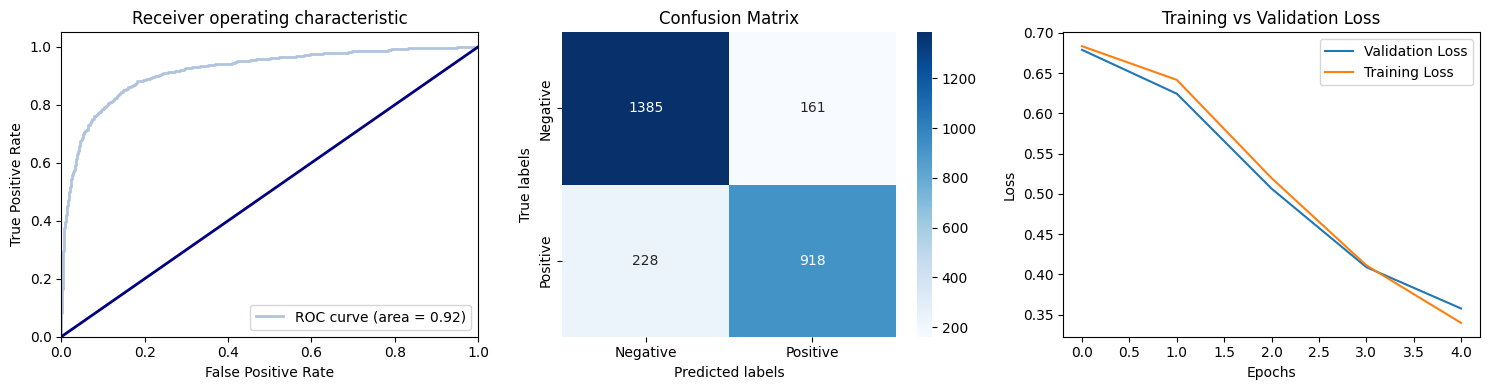

In [ ]:
# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model_name = 'BERT' # name for saving

# Train the model
model, tokenizer, val_losses, training_loss_values = train_model(model, tokenizer, X_train, y_train, X_val, y_val, batch_size = 64, learning_rate=2e-6, gradient_accumulation_steps = 2, modelName=path+'/result/'+model_name)

# Test the model
y_true, y_pred, y_pred_prob = test_model(model, tokenizer, X_val, y_val)

# Print the classification report
# plot/ show evaluation
show_evaluation_results(y_true, y_pred, y_pred_prob)

show_validation_loss(val_losses, training_loss_values)

## 2. Apply Results to Test Data

Predict for Test Data using BERT Model and Save results to Dataframe

In [ ]:
# Load test data
predicted_sentiment, probabilities = predict_sentiment(model, tokenizer, data_test.text.values.flatten())
data_test['Sentiment (BERT)'] = predicted_sentiment
data_test['Negative (BERT)'] = probabilities[:, 0]
data_test['Positive (BERT)'] = probabilities[:, 1]
data_test.head(10)

In [ ]:
data_test.to_csv(path+'/data_output/bert_data_all.csv', index=False)
data_test.head(5)

# I - 2) XLNet

The XLNet model was proposed in [`XLNet: Generalized Autoregressive Pretraining for Language Understanding`](https://arxiv.org/abs/1906.08237) by Zhilin Yang, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, Quoc V. Le. XLnet is an extension of the Transformer-XL model pre-trained using an autoregressive method to learn bidirectional contexts by maximizing the expected likelihood over all permutations of the input sequence factorization order.

For a more powerful but slower working model, change `xlnet-base-cased` to `xlnet-large-cased`.

## 1. Training Loop and Evaluation

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
0,0.700300,0.673616,0.577266,0.528970,0.553721,0.541646,8.875900,303.293000
1,0.637000,0.611181,0.679792,0.625622,0.714817,0.637343,8.874000,303.359000
2,0.465900,0.408210,0.841010,0.834032,0.845189,0.828842,8.904500,302.318000
3,0.349900,0.323020,0.866642,0.863033,0.864873,0.861543,8.911900,302.066000
4,0.308800,0.319976,0.868871,0.865615,0.866485,0.864838,8.896700,302.583000


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1546
           1       0.85      0.84      0.84      1146

    accuracy                           0.87      2692
   macro avg       0.87      0.86      0.87      2692
weighted avg       0.87      0.87      0.87      2692



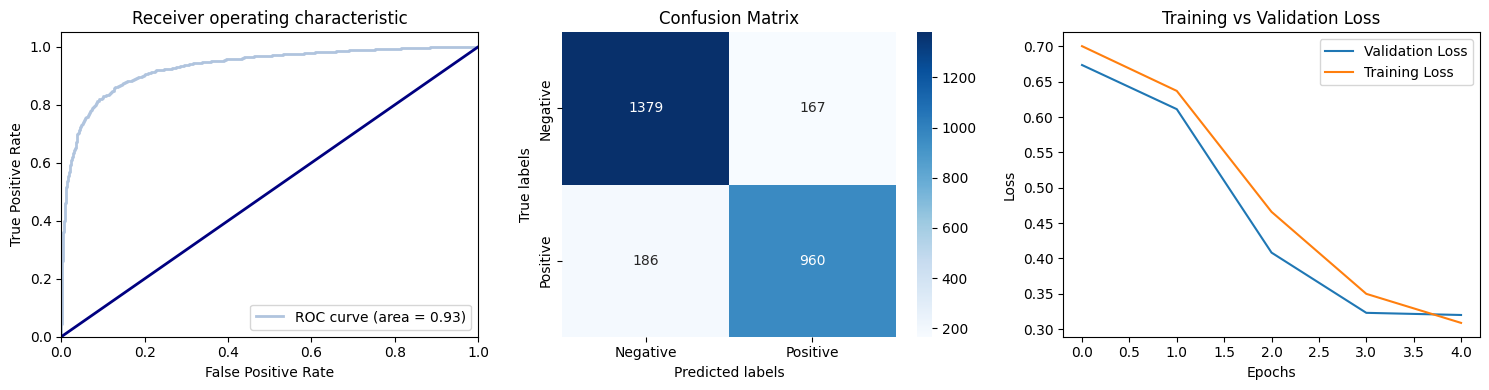

In [ ]:
from transformers import XLNetForSequenceClassification, XLNetTokenizer

# Load the pre-trained BERT model
model_xlnet = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Load pre-trained XLNet model
tokenizer_xlnet = XLNetTokenizer.from_pretrained('xlnet-base-cased')

model_name = 'XLNet'

# Train the model
model_xlnet, tokenizer_xlnet, val_losses, training_loss_values = train_model(model_xlnet, tokenizer_xlnet, X_train, y_train, X_val, y_val, learning_rate=9e-7, batch_size= 32, gradient_accumulation_steps = 2, epochs=5, modelName=path+'/result/'+model_name)

# Test the model
y_true, y_pred, y_pred_prob = test_model(model_xlnet, tokenizer_xlnet, X_val, y_val)

# Print the classification report
# plot/ show evaluation
show_evaluation_results(y_true, y_pred, y_pred_prob)

show_validation_loss(val_losses, training_loss_values)

## 2. Apply Results to Test Data

Predict for Test Data using XLNet Model and Save results to Dataframe

In [ ]:
predicted_sentiment, probabilities = predict_sentiment(model_xlnet, tokenizer_xlnet, data_test['text'].values.flatten())
data_test['Sentiment (XLNet)'] = predicted_sentiment
data_test['Negative (XLNet)'] = probabilities[:, 0]
data_test['Positive (XLNet)'] = probabilities[:, 1]

data_test.to_csv(path+'/data_output/xlnet_data_all.csv', index=False)
data_test.head(5)

# J - 3) FinBERT

FinBERT is a Bert-based large language model that adapts to the finance domain proposed by Huang et al. in [`FinBERT - A Large Language Model for Extracting Information from Financial Text`](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3910214). It was trained on a model fine-tuned on 10,000 manually annotated sentences from analyst reports of S&P 500 firms.

## 1. Training Loop and Evaluation

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/533 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
0,2.373600,2.263985,0.587667,0.445240,0.510855,0.394904,5.103800,527.445000
1,0.742900,0.725085,0.796434,0.529541,0.535113,0.525183,5.103200,527.510000
2,0.399900,0.406540,0.841753,0.836602,0.840953,0.833778,5.108000,527.019000
3,0.392300,0.371552,0.852155,0.846828,0.853269,0.843059,5.117300,526.060000
4,0.357600,0.365554,0.854383,0.849477,0.854607,0.846242,5.098400,528.010000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1546
           1       0.86      0.79      0.82      1146

    accuracy                           0.85      2692
   macro avg       0.85      0.85      0.85      2692
weighted avg       0.85      0.85      0.85      2692



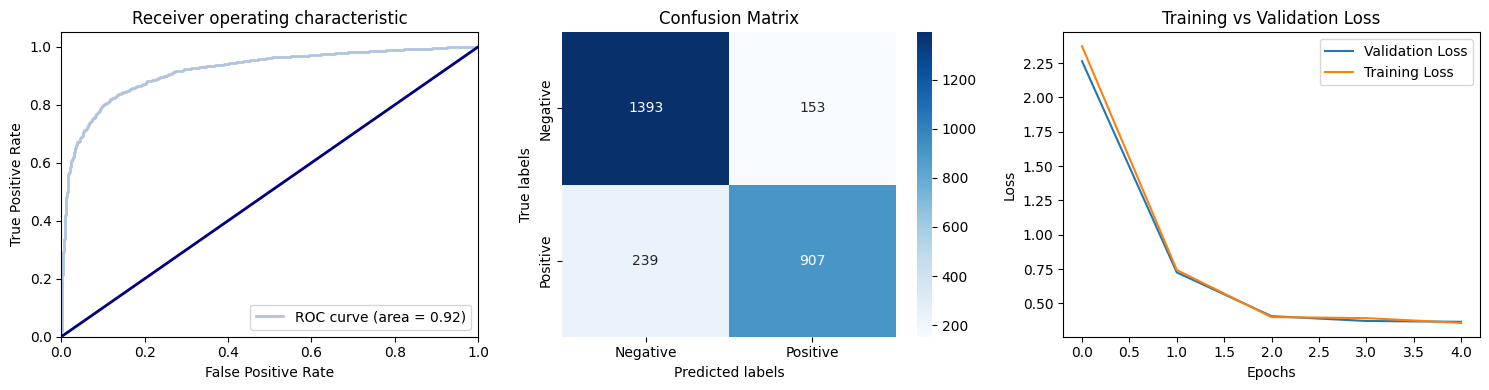

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the pre-trained tokenizer and model
tokenizer_finbert = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

model_name = 'FinBERT'

# Train the model
model_finbert, tokenizer_finbert, val_losses, training_loss_values = train_model(model_finbert, tokenizer_finbert, X_train, y_train, X_val, y_val, batch_size = 32, gradient_accumulation_steps = 2, learning_rate=1e-6, epochs=5, modelName=path+'/result/'+model_name)

# Test the model
y_true, y_pred, y_pred_prob = test_model(model_finbert, tokenizer_finbert, X_val, y_val)

# Print the classification report
# plot/ show evaluation
show_evaluation_results(y_true, y_pred, y_pred_prob)

show_validation_loss(val_losses, training_loss_values)

## 2. Apply Results to Test Data
Predict for Test Data using FinBERT Model and Save results to Dataframe

In [ ]:
predicted_sentiment, probabilities = predict_sentiment(model_finbert, tokenizer_finbert, data_test['text'].values.flatten())
data_test['Sentiment (FinBERT)'] = predicted_sentiment
data_test['Negative (FinBERT)'] = probabilities[:, 0]
data_test['Positive (FinBERT)'] = probabilities[:, 1]

data_test.to_csv(path+'/data_output/finbert_data_all.csv', index=False)
data_test.head(5)

# K - 4) RoBERTa

The RoBERTa model is a BERT-based model that was proposed in [`RoBERTa: A Robustly Optimized BERT Pretraining Approach`](https://arxiv.org/abs/1907.11692) by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov. It is based on Google’s BERT model released in 2018. It modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

## 1. Training Loop and Evalutation

To use a more powerful model change `roberta-base` to `roberta-large` in following code.

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
0,0.689700,0.684815,0.574294,0.364795,0.287147,0.500000,10.447200,257.678000
1,0.679900,0.681563,0.574294,0.364795,0.287147,0.500000,10.456900,257.437000
2,0.672900,0.672819,0.574294,0.364795,0.287147,0.500000,10.450500,257.596000
3,0.545200,0.456260,0.859955,0.851814,0.874572,0.843755,10.447400,257.672000
4,0.273600,0.291626,0.884844,0.882349,0.882019,0.882696,10.456200,257.455000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1546
           1       0.86      0.87      0.87      1146

    accuracy                           0.88      2692
   macro avg       0.88      0.88      0.88      2692
weighted avg       0.88      0.88      0.88      2692



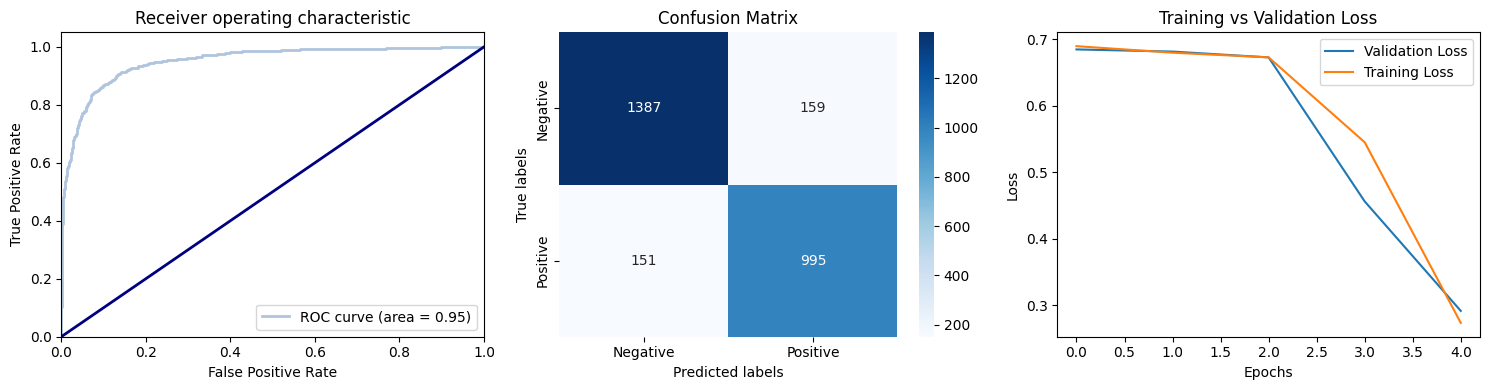

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load the pre-trained tokenizer and model
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

model_name = 'RoBERTa'

# Train the model
model_roberta, tokenizer_roberta, val_losses, training_loss_values = train_model(model_roberta, tokenizer_roberta, X_train, y_train, X_val, y_val, batch_size = 64, gradient_accumulation_steps = 2, learning_rate=1e-6, epochs=5, modelName=path+'/result/'+model_name)

# Test the model
y_true, y_pred, y_pred_prob = test_model(model_roberta, tokenizer_roberta, X_val, y_val)

# Print the classification report
# plot/ show evaluation
show_evaluation_results(y_true, y_pred, y_pred_prob)

show_validation_loss(val_losses, training_loss_values)

## 2. Apply Results to Test Data

Predict for Test Data using Roberta Model and Save results to Dataframe

In [ ]:
predicted_sentiment, probabilities = predict_sentiment(model_roberta, tokenizer_finbert, data_test['text'].values.flatten())
data_test['Sentiment (Roberta)'] = res[0]
data_test['Negative (Roberta)'] = res[1][:, 0]
data_test['Positive (Roberta)'] = res[1][:, 1]

data_test.to_csv(path+'/data_output/roberta_data_all.csv', index=False)
data_test.head(5)